In [1]:
import os
import sys
import random
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from scipy import stats
import nibabel as nib

import torch
from torch import optim
import torch.nn as nn
import torchvision
import torchio as tio

sys.path.insert(1, '../code')
from tio_preprocessing import TIOPreprocessing
from model import UNet

Dataset size: 37 subjects
Subject(Keys: ('T2w',); images: 1)
ScalarImage(shape: (1, 300, 320, 208); spacing: (0.80, 0.80, 0.80); orientation: PSR+; dtype: torch.ShortTensor; memory: 38.1 MiB)


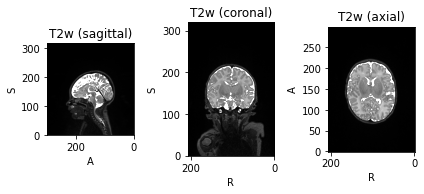

In [3]:
WU_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/WashU'
T2_dir = Path(os.path.join(WU_path, 'orig'))
T2_paths = sorted(T2_dir.glob('*.nii.gz'))

subjects = []
for T2_path in T2_paths:
    subject = tio.Subject(
        T2w=tio.ScalarImage(T2_path)
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')
subject_0 = dataset[0]
print(subject_0)
print(subject_0.T2w)

subject_0.plot()




In [4]:
def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

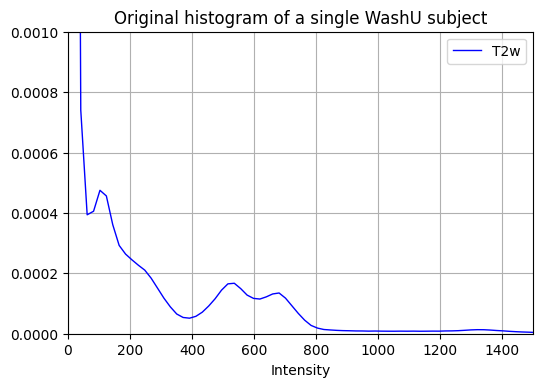

In [5]:
fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, subject_0.T2w.data, label='T2w', alpha=1, color='blue')
ax.set_title('Original histogram of a single WashU subject')
ax.set_xlabel('Intensity')
ax.set_ylim(0, 0.001)
ax.set_xlim(0, 1500)
ax.legend()
ax.grid()

In [6]:
input = T2_paths[0]
temp = os.path.join(os.path.dirname(T2_paths[0]).replace('orig', 'temp'), os.path.basename(T2_paths[0]).replace('_T2w.nii.gz', ''))
output = os.path.dirname(T2_paths[0]).replace('orig', 'pre')
print(input)
print(temp)
print(output)

exec(open('/usr/share/Modules/init/python.py').read())
module('load fsl')
module('load ants')
module('load python3/3.8.3_anaconda2020.07_mamba')

!/home/faird/shared/projects/3D_MRI_GAN/tio_unet/code/setup_input_image.sh $input $temp $output

/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/WashU/orig/sub-4000_ses-030321_T2w.nii.gz
/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/WashU/temp/sub-4000_ses-030321
/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/WashU/pre
 
 START: ACPCAlignment
Final FOV is: 
0.000000 208.000000 0.000000 300.000000 71.000000 150.000000 

 
 END: ACPCAlignment


Dataset size: 1 subjects
Subject(Keys: ('T2w',); images: 1)
ScalarImage(shape: (1, 182, 218, 182); spacing: (1.00, 1.00, 1.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 27.5 MiB)


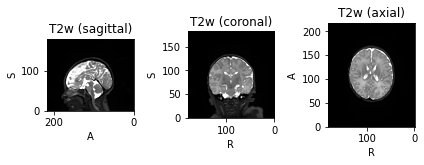

In [7]:
WU_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/WashU'
T2_dir = Path(os.path.join(WU_path, 'pre'))
T2_paths = sorted(T2_dir.glob('*.nii.gz'))

subjects = []
for T2_path in T2_paths:
    subject = tio.Subject(
        T2w=tio.ScalarImage(T2_path)
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')
subject_0 = dataset[0]
print(subject_0)
print(subject_0.T2w)

subject_0.plot()

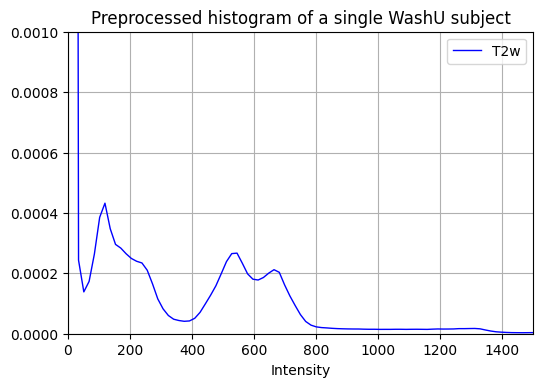

In [8]:
fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, subject_0.T2w.data, label='T2w', alpha=1, color='blue')
ax.set_title('Preprocessed histogram of a single WashU subject')
ax.set_xlabel('Intensity')
ax.set_ylim(0, 0.001)
ax.set_xlim(0, 1500)
ax.legend()
ax.grid()

Dataset size: 62 subjects
Subject(Keys: ('T1w', 'T2w'); images: 2)
ScalarImage(shape: (1, 182, 218, 182); spacing: (1.00, 1.00, 1.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 27.5 MiB)
ScalarImage(shape: (1, 182, 218, 182); spacing: (1.00, 1.00, 1.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 27.5 MiB)


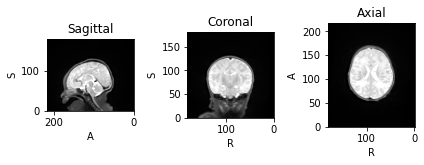

In [9]:
# EDA of training data used for model
training_dir = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/training_data/ECHO_pre'
T1_dir = Path(os.path.join(training_dir, 'T1w'))
T2_dir = Path(os.path.join(training_dir, 'T2w'))
T1_paths = sorted(T1_dir.glob('*.nii.gz'))
T2_paths = sorted(T2_dir.glob('*.nii.gz'))
assert len(T1_paths) == len(T2_paths)

subjects = []
for (T1_path, T2_path) in zip(T1_paths, T2_paths):
    subject = tio.Subject(
        T1w=tio.ScalarImage(T1_path),
        T2w=tio.ScalarImage(T2_path)
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')
training_subject_0 = dataset[0]
print(training_subject_0)
print(training_subject_0.T1w)
print(training_subject_0.T2w)
training_subject_0.T2w.plot()

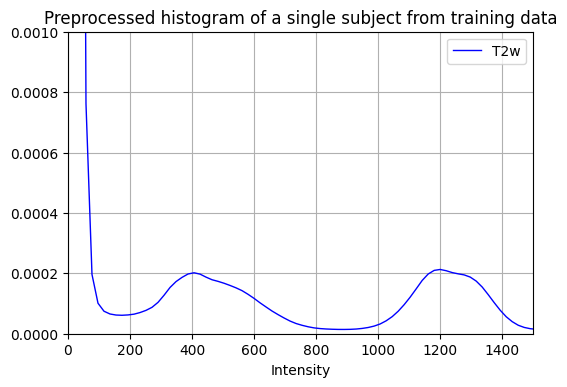

In [11]:
fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, training_subject_0.T2w.data, label='T2w', alpha=1, color='blue')
ax.set_title('Preprocessed histogram of a single subject from training data')
ax.set_xlabel('Intensity')
ax.set_ylim(0, 0.001)
ax.set_xlim(0, 1500)
ax.legend()
ax.grid()

In [12]:
# Histogram normalization was used in preprocessing according to the config file
T1w_histogram_landmarks_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/training_data/ECHO_T1w_landmarks.npy'
T2w_histogram_landmarks_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/training_data/ECHO_T2w_landmarks.npy'

if os.path.exists(T1w_histogram_landmarks_path) and os.path.exists(T2w_histogram_landmarks_path):
    T1_landmarks = np.load(T1w_histogram_landmarks_path)
    T2_landmarks = np.load(T2w_histogram_landmarks_path)
else:
    T1_landmarks = tio.HistogramStandardization.train(
        T1_paths,
        output_path = T1w_histogram_landmarks_path,
    )
    T2_landmarks = tio.HistogramStandardization.train(
        T2_paths,
        output_path = T2w_histogram_landmarks_path,
    )
    
np.set_printoptions(suppress=True, precision=3)
print('\nTrained T1w landmarks', T1_landmarks)
print('\nTrained T2w landmarks', T2_landmarks)




Trained T1w landmarks [  0.      0.      1.006   1.272   1.458   1.813   2.129   2.471   2.981
   3.429   4.312  63.262 100.   ]

Trained T2w landmarks [  0.      0.      0.305   0.398   0.472   0.622   0.819   1.079   1.48
   1.805   2.391  29.573 100.   ]


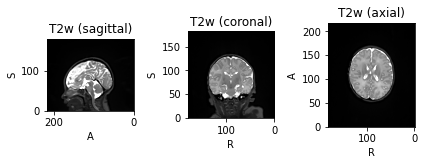

In [13]:
histogram_transform = tio.HistogramStandardization({'T2w': T2_landmarks})

subject_0_std = histogram_transform(subject_0)

subject_0_std.plot()

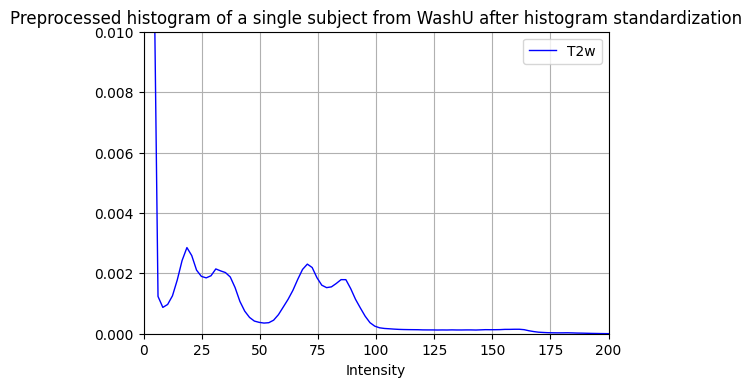

In [20]:
fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, subject_0_std.T2w.data, label='T2w', alpha=1, color='blue')
ax.set_title('Preprocessed histogram of a single subject from WashU after histogram standardization')
ax.set_xlabel('Intensity')
ax.set_ylim(0, 0.01)
ax.set_xlim(0, 200)
ax.legend()
ax.grid()

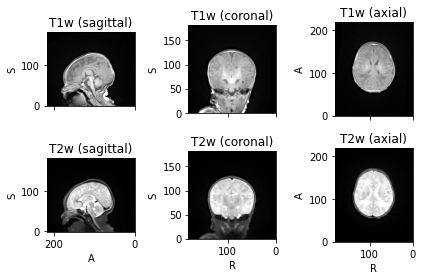

In [16]:
histogram_transform = tio.HistogramStandardization({'T1w': T1_landmarks, 'T2w': T2_landmarks})

training_subject_0_std = histogram_transform(training_subject_0)

training_subject_0_std.T2w.plot()

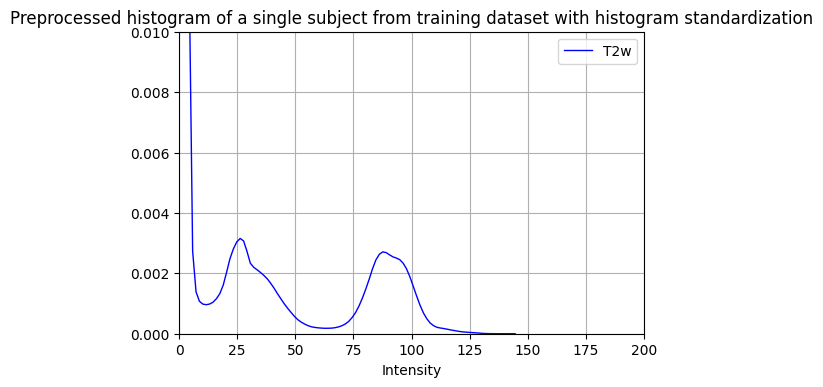

In [21]:
fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, training_subject_0_std.T2w.data, label='T2w', alpha=1, color='blue')
ax.set_title('Preprocessed histogram of a single subject from training dataset with histogram standardization')
ax.set_xlabel('Intensity')
ax.set_ylim(0, 0.01)
ax.set_xlim(0, 200)
ax.legend()
ax.grid()